# Simple AI Assistant

In [1]:
import os
from dotenv import load_dotenv
from typing import Annotated, Literal, TypedDict
from IPython.display import Image, display
import functools

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode


load_dotenv()
openai_api_key = os.environ["OPENAI_API_KEY"]

In [2]:
search_template = """Your job is to search the web for related news that would be relevant to generate the article described by the user.

                  NOTE: Do not write the article. Just search the web for related news if needed and then forward that news to the outliner node.
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article.
                    """

writer_template = """Your job is to write an article, do it in this format:

                        TITLE: <title>
                        BODY: <body>

                      NOTE: Do not copy the outline. You need to write the article but abide by the outline.

                       ```
                    """

In [3]:
# Step 1: define LLM
llm = ChatOpenAI(
    api_key=openai_api_key, 
    model="gpt-4o-mini", 
    temperature=0
)

# Step 2: define Agent State
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

# Step 3: define tools
tools = [TavilySearchResults(max_results=5)]

# Step 4: define agent function, and assign tools
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm
  
# Step 5: Define agents
search_agent = create_agent(llm, tools, search_template)
outliner_agent = create_agent(llm, [], outliner_template)
writer_agent = create_agent(llm, [], writer_template)

# Step 6: Define agent invoke
def agent_node(state, agent, name):
  result = agent.invoke(state)
  return {
      'messages': [result]
  }

# Step 7: ?
search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")

tool_node = ToolNode(tools)

### Define workflow for Agents

#### Define decision point

In [4]:
def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (send state to outliner)
    return "outliner"

In [5]:
workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)

# add edges
workflow.set_entry_point("search")
workflow.add_conditional_edges(
    "search",
    should_search
)
workflow.add_edge("tools", "search")
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", END)

graph = workflow.compile()

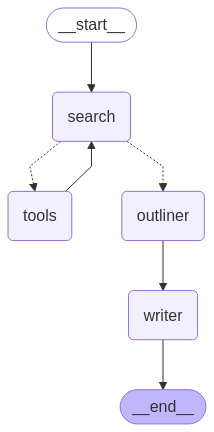

In [6]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Invoke Graph

In [7]:
question = "Jaki jest potencjał wykorzystania technologii generatywnych w inwestowaniu na giełdzie? Zaproponuj scenariusze użycia i przykładowe tematy magisterskie z Data Science."

input_message = HumanMessage(content=question)

for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Jaki jest potencjał wykorzystania technologii generatywnych w inwestowaniu na giełdzie? Zaproponuj scenariusze użycia i przykładowe tematy magisterskie z Data Science.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rh5XG6lBVCKhINHkh2L2caF0)
 Call ID: call_rh5XG6lBVCKhINHkh2L2caF0
  Args:
    query: generative technology in stock market investing
  tavily_search_results_json (call_pjVaJHuuisPl46wyt2CpTsH0)
 Call ID: call_pjVaJHuuisPl46wyt2CpTsH0
  Args:
    query: use cases of generative AI in finance
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Generative AI in the Finance Function of the Future | BCG", "url": "https://www.bcg.com/publications/2023/generative-ai-in-finance-and-accounting", "content": "Generative AI in the Finance Function of the